# Time Series Analysis Tool

This notebook exists to allow time series analysis of pixels or areas.

This notebook has been setup to work with table of contents and heading collapsing extensions. These are definitely worth using!

The output is an interactive matplotlib figure with two scenes from the area of interest rendered in true colour, along with scatter plots for the two main bands of interest for each scene, and an average spectral signature for each scene.

The main benefit to this visualistion though is the ability to see the the time series trend for a band or number of bands for a given pixel or area. This is one in a single chart, which also indicates the relative location of each of the scenes being viewed on the timeseries, and also shows some key threshold lines.

This particular notebook has been written to look at output from Peter's urban change detection algorithm, however, it is hoped that it should easily by ported to others' anaylsis problems with only minor tweaks, as long as the Xarray is setup the same, all that should be required is to:
<ul><li> exclude the code that displays the urban change algorithm outputs
<li> exclude the problem specific code (such as thresholds and change date range) on the TS analysis plot</ul>

## Imports

In [1]:
%matplotlib notebook
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import gdal

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider, Dropdown
from IPython.display import display

from skimage import exposure
from scipy.signal import lfilter

import warnings

# Setup

The goal is to get the data into an Xarray. The graphing code is written to work with an Xarray with the coordinates/dimensions (X, Y, time, bands).

## Importing the data
This code is specific to the intermediate output files from Peter's urban change algorithm.

In [2]:
# build a list of all files in the directory (ie the folder for that location)
location = 'mtbarker/'
files = os.listdir(location)

# build a list of all the NBAR*.img file names and which bands they represent
NBARfiles = []
bands = []
for file in files:
    if file[-4::] == '.img' and file[0:4] == 'NBAR':
        NBARfiles.append(file)
        bands.append(file.split('NBAR_')[1].split('.img')[0])

# open all the .img files with NBAR in the name, convert to numpy array, swap axes so order is (x, y, t)
# and save to dict
raw_data = {}
for i in range(len(NBARfiles)):
    raw_data[bands[i]] = gdal.Open(location + NBARfiles[i]).ReadAsArray().swapaxes(0,2)
num_scenes = len(raw_data['red'][0][0])

# build a list of all the dates represented by each band in the NBAR files
# reuse the list of NBAR file names, but this time access the .hdr file
in_dates = False
dates = []
for line in open(location + NBARfiles[0].split('.img')[0] + '.hdr'):
    if line[0] == '}':
        continue
    if in_dates:
        dates.append(line.split(',')[0].strip())
    if line[0:10] == 'band names':
        in_dates = True

# save list of satellite originated bands
sat_bands = bands.copy()

# add the yet to be calculated derivative bands to the overall bands list
bands += ['evi', 'ndvi', 'albedo', 'cloud_mask']

### Building the Xarray

In [3]:
# define the size for the numpy array that will hold all the data for conversion into XArray
x = len(raw_data['red'])
y = len(raw_data['red'][0])
t = len(raw_data['red'][0][0])
n = len(bands)

# create an empty numpy array of the correct size
alldata = np.zeros((x, y, t, n), dtype=np.float32)

# populate the numpy array with the satellite data
# turn all no data NBAR values to NaNs
for i in range(len(sat_bands)):
    alldata[:,:,:,i] = raw_data[sat_bands[i]]
    alldata[:,:,:,i][alldata[:,:,:,i] == -999] = np.nan
    
# convert the numpy array into an xarray, with appropriate lables, and axes names
data = xr.DataArray(alldata, coords = {'x':range(x), 'y':range(y), 'date':dates, 'band':bands},
             dims=['x', 'y', 'date', 'band'])

### Opening the results from the urban change algorithm

In [4]:
# open the results of the change algorithm, and format for eay plotting
change = gdal.Open(location + 'change_time.img').ReadAsArray()

# remove the dates, so you have a mask for change or no change
change_flat_mask = change.copy()
change_flat_mask[change_flat_mask != 0] = 1
change_flat_mask[change_flat_mask == 0] = np.nan

### Creating the calculated "bands"

In [5]:
# calculate NDVI "band"
a = (data.loc[:,:,:,'nir'] - data.loc[:,:,:,'red'])
b = (data.loc[:,:,:,'nir'] + data.loc[:,:,:,'red'])
b_pos = b.where(b.values > 0)
data.loc[:,:,:,'ndvi'] = np.nan
data.loc[:,:,:,'ndvi'] = a/b_pos

# calculate EVI "band"
g  = 2.5
c1 = 6
c2 = 7.5
l  = 1
data.loc[:,:,:,'evi'] = g * ((a/10000) /
    ((data.loc[:,:,:,'nir']/10000) + (c1 * (data.loc[:,:,:,'red']/10000)) - (c2 * (data.loc[:,:,:,'blue']/10000)) + l))

# calculate average albedo "band"
for band in sat_bands:
    data.loc[:,:,:,'albedo'] += data.loc[:,:,:,band]
data.loc[:,:,:,'albedo'] = data.loc[:,:,:,'albedo'] / (6 * 1000)

# import cloudmask and add to xarray
cloudmask = gdal.Open(location + '/tsmask.img').ReadAsArray().swapaxes(0,2)
data.loc[:,:,:,'cloud_mask'] = cloudmask

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


# Defining Functions

## Data Preparation and Manipulation Functions

### getTimeSeries

In [6]:
def getTimeSeries(xpos, ypos, ts_bands, apply_cloud_mask = True):
    """
    This function retrives the time series data for a given pixel and band.
    It then applies the cloud/shadow mask (if requested) to the results and to the dates for each scene.
    Finally, it returns the good pixels for each of the requested bands as a multi column pandas dataframe,
    with the date formatted as a datetime object and set as in the index
    
    Possible flaw with logic by only masking pixels when they are clouded, not entire query area if any or some
    is partially clouded. Need to explore this thought further
    """       
    if isinstance(xpos, list) and len(xpos) == 1:
        xpos.append(xpos[0] + 1)
    elif not isinstance(xpos, list) and is_number(xpos):
        xpos = [int(xpos), xpos + 1]
        
    if isinstance(ypos, list) and len(ypos) == 1:
        ypos.append(ypos[0] + 1)
    elif not isinstance(ypos, list) and is_number(ypos):
        ypos = [int(ypos), ypos + 1]
    
    # if looking for an area and not masking for cloud, do this
    if not apply_cloud_mask:
        ts_data = pd.DataFrame(data[xpos[0]:xpos[1], ypos[0]:ypos[1],:].sel(band = ts_bands).mean(dim=['x','y'], skipna = True).to_pandas())
        
    # if looking for an area and masking for cloud, do this
    else:
        ts_data = pd.DataFrame(data[xpos[0]:xpos[1], ypos[0]:ypos[1], :].sel(band = ts_bands).where(
            data[xpos[0]:xpos[1], ypos[0]:ypos[1], :].sel(band ='cloud_mask') == 0).mean(dim=['x','y'], skipna = True).to_pandas())
    
    ts_data.index = pd.to_datetime(ts_data.index) 
    ts_data.columns = [ts_bands]
    return ts_data

### filterNoise

In [7]:
def filterNoise(df):
    """
    This function applies a scipy.signal.lfilter IIR filter to the time series data to smooth out
    some of the spikes that are visible in this timeseries for each of the columns in the supplied
    pandas dataframe.
    Peters C++ code used a different filter, so this function may be replaced or deprecated in the
    future
    """
    # set up required parameters for the function
    n = 15                 # bigger n means more smoothing
    b = [1.0 / n] * n
    a = 1      
    for col in df.columns:
        df[col] = lfilter(b, a, df[col])
    return df

### calcRollingAvg

In [8]:
def calcRollingAvg(df, window = '365D', min_periods = 6):
    """
    The function uses the pandas rolling average function to calculate the yearly rolling
    average of the bands. It returns the dataframe it was given with the column values modified
    by the rolling average function.
    The window size and minimum number of periods for the average to be considered valid are optional
    parameters
    Peter's code used either 1 or 2 years windows depending on frequency of valid observations - this might
    be included in the future
    """
    for col in df.columns:
        df[col] = df[col].rolling(window = window, min_periods = min_periods).mean()
    return df

### calcYearDiff

In [9]:
def calcYearDiff(df, years = 1):
    """
    Returns the difference between a timeseries and the timeseries at some point in the future.
    It does this by joining a time adjusted series onto the original data and interpolating any missing
    dates, and then cleaning up the NaN mess resulting.
    """
    # convert years to days
    days = years * 365
    
    # duplicate data
    df2 = df.copy()

    # reduce the index by a year, essentially moving the average for the following year back one
    # this might need a bit of tweaking to deal with leap years...?
    df2.index = np.array(df2.index) - np.timedelta64(days, 'D')
    
    # building lists of column names that will be needed
    cols = list(df.columns)
    newcols = []
    interpcols = []
    diffcols = []
    for col in cols:
        newcols.append(col + '-1y')
        interpcols.append(col + '-1y_interp')
        diffcols.append(col + '_diff')
    
    # rename df2 columns to avoid clashes in the merge
    df2.columns = newcols

    # SQL style outer join (ie all data is kept, NaNs for blank values)
    df = pd.merge(df, df2, left_index=True, right_index=True, how='outer')
 
    # interpolate the timeseries values in the future and calculate the difference from that date
    for i in range(len(cols)):
        df[interpcols[i]] = df[newcols[i]].interpolate(method='time')
        df[diffcols[i]] = df[interpcols[i]] - df[cols[i]]

    # tidying up unwanted rows and columns
    # can do dropna because if there was no original data, the difference calc result is NaN
    df = df.dropna(subset=[diffcols])
    df = df.drop(cols + newcols + interpcols, axis = 1)
    return df

### gatherAndPrepTSData

In [10]:
def gatherAndPrepTSData(xpos,ypos,ts_bands):
    """
    This function takes the x and y coordinates of interest, along with the ts_bands dict.
    It pulls the required data from the xarray, and applies the various processing steps specified in the dict
    It returns a pandas dataframe of all the processed data, with a date index, and each column named as
    specified in the dict.
    """
    dfs = []
    cols = []
    # ts_bands is the very important dict, it specifies the name of the result, the band the result is built
    # off, and which of the processing steps will be performed on that band data
    for TS in ts_bands:
        df = getTimeSeries(xpos, ypos, TS['band'], apply_cloud_mask = TS['cloud_mask'])
        # drop rows with clouds masked
        df = df.dropna(axis = 0, how = 'all')

        # filter noise
        if TS['smoothed']:
            df = filterNoise(df)

        # calculate rolling average
        if TS['RollingAve']:
            df = calcRollingAvg(df)
            # drop rows with no rolling average values
            df = df.dropna(axis = 0, how = 'all')

        # calculate difference between TS value and a period into the future
        if TS['TSDiff']:
            df = calcYearDiff(df)
        
        dfs.append(df)
        cols.append(TS['name'])
    dfs = pd.concat(dfs, axis = 1)
    dfs.columns = cols
    return dfs

## Helper functions for plotting and other

### define_TS_YAxisRange

In [11]:
def define_TS_YAxisRange(data, DiffTS = False, n_stddevs = 0.5):
    """
    This function defines the y axis range for a timeseries plot of a given band (supplied as a pandas 
    single column dataframe or series, aka data. It calculates the standard deviation of the data, and 
    returns a list with the lowest and highest values for the axes based on the number of standard deviations
    away from the mean (which can be varied through the second parameter as desired)
    """
    if DiffTS:
        mag = data.std(skipna = True) * n_stddevs
        return [-mag, mag]
    else:
        mean = data.mean(skipna = True)
        std = data.std(skipna = True)
        low = mean - (n_stddevs * std)
        hi = mean + (n_stddevs * std)
        return [low,hi]

### is_number

In [12]:
def is_number(s):
    """
    A quick helper function pinched from stack overflow to test if a variable is a float or int
    """
    try:
        float(s)
        return True
    except ValueError:
        return False
    

### getSceneFilteredIndex

In [13]:
def getSceneFilteredIndex(scene_num, df):
    """
    This function find the X axis location needed for a given scene to be displayed on the Time Series View.
    This is used draw the lines on the timeseries that represent the scenes being viewed.
    If the scene being viewed is part of that pixel's timeseries, the line returned is a solid line.
    If the scene being viewed is not part of that pixel's timeseries (due to cloud masking), the
    line returned is a dashed line.
    The line is returned as a number, linestyle pair, for plugging into the matplotlib.axvline function
    """
    # find the date of the scene_number from the list of all dates before clouds mask application
    linedate = pd.to_datetime(dates[scene_num])
    
    # for the simple case, when the scene is part of the pixel's time series
    if linedate in df.index:
        nearest_num = df.index.get_loc(linedate)
        return [nearest_num, '-']
    
    # when the pixel is not part of the time series and is more recent than the most recent valid
    # scene, use the last valid scenes index
    elif linedate > df.index[-1]:
        nearest_num = df.index.get_loc(df.index[-1])
        return [nearest_num, '--']
    
    # when the schene is not part of the pixel's time series, draw the line at the first valid scene's
    # index AFTER the scene in question
    else:   
        nearest_num = df.index.get_loc(df[df.index > linedate].index[0])
        return [nearest_num, '--']

### getChangePeriodTimeRange

In [14]:
def getChangePeriodTimeRange(df, daterange):
    """
    This function changes the calculated change date from Peter's algorithm and converts it
    to the equivalent range of row numbers for the given timeseries (supplied as a pandas dataframe).
    The change date calculated is converted to the start and end dates of the quarter, and this is 
    turned into a datetime object, and used in boolean masking to define the first and last row
    of that interval
    """
    # flaw with the logic here, if someone passes a daterange with more than 2 entries, only the first
    # and last are used. So it works, as long as its used well.
    for i in range(len(daterange)):
        year = str(int(daterange[i]))    
        # generate the string equivalents of the start and end dates for the quarter
        if daterange[i] % 1 == 0.125:
            start = '-01-01'
            end = '-03-31'
        if daterange[i] % 1 == 0.375:
            start = '-04-01'
            end = '-06-30'
        if daterange[i] % 1 == 0.625:
            start = '-07-01'
            end = '-09-30'
        if daterange[i] % 1 == 0.875:
            start = '-10-01'
            end = '-12-31'
        if i == 0:
            startdate = pd.to_datetime(year + start) # turn strings into datetime objects
        else:
            enddate = pd.to_datetime(year + end)    
    
    # calculdate the start and end date index of the range bounded by start and end datetimes
    start_idx = df[(df.index >= startdate) & (df.index <= enddate)].index[0]
    end_idx = df[(df.index >= startdate) & (df.index <= enddate)].index[-1]    
  
    # get the row number of the start and end indexes
    start_row = df.index.get_loc(start_idx)    
    end_row = df.index.get_loc(end_idx)
    
    # return result as a list, ready to directly be passed to axis.set_ylim()
    return [start_row, end_row]

### getChangeDate

In [15]:
def getChangeDate(xpos, ypos):
    """
    This function returns the max and min change date for a given range of pixels based on the
    output of the algorithm. It works if the range is only a single pixel.
    It returns a string if there was no change detected in that area.
    """
    # select the pixels in the area of interest
    pix = change[ypos[0]:ypos[1], xpos[0]:xpos[1]]
    # mask for > 0
    pix = pix[pix > 0]
    # if there are no pixels > 0, break things
    if len(pix) == 0:
        return "No Change"
    # find hte max and min and return them as a list
    mini = pix.min()
    maxi = pix.max()
    return [mini, maxi]

## Plotting Functions

### drawScene

In [16]:
def drawScene(scene_num, change_trans  = 1, xpos, ypos):
    """
    This function draws a landsat scene from the data in true colour, and overlays the results of the
    change detection algorithm. The scene to be displayed is determined by the scene_num parameter, while the
    transparency (alpha) of the change results is dictacted by the change_trans parameter (0 = transparent,
    1 = totally opaque). It formats the axes appropriately and returns the axes to the caller.
    It also displays the bounding box of the pixels being analysed.
    """
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # define the current colour map to display the change results raster properly
    current_cmap = matplotlib.cm.get_cmap('Reds_r')
    current_cmap.set_under('k', alpha=0.0)
    current_cmap.set_over('r', alpha=1.0)
    current_cmap.set_bad('k', alpha=0.0)  
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    RGB = ['R','G','B']
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + dates[scene_num] + ', over ' + location)
    ax.imshow(change_flat_mask, alpha = change_trans, interpolation='none', cmap = current_cmap, clim = [0.5, 0.6])
    
    # plot up the displayed pixel, or draw a box around the queried pixels
    # logic re . vs box could be improved here
    height = abs(ypos[1] - ypos[0])
    width = abs(xpos[1] - xpos[0])
    if height > 2 and width > 2:
        rect = matplotlib.patches.Rectangle((xpos[0],ypos[0]), abs(xpos[1] - xpos[0]), abs(ypos[1] - ypos[0]),
                                            color = 'blue', linestyle = '-', fill = False, alpha = change_trans)
        ax.add_patch(rect)
    else:
        ax.plot((xpos[0] + xpos[1])/2, (ypos[0] + ypos[1])/2, color = 'b', marker = '.', alpha = change_trans)
    return ax

SyntaxError: non-default argument follows default argument (<ipython-input-16-a8e834bcdb75>, line 1)

### drawSpectrum

In [ ]:
def drawSpectrum(xpos, ypos, scene_num):
    """
    This function draws the spectral signature for a selected range of pixels in a selected scene.
    It gathers the data together, averages the band values, and returns them plotted on nicely labelled
    axes, which are returned to the caller
    """
    # include Landsat-8 bands incase of future work
    bandorder = {'ultrablue':1, 'blue':2, 'green':3, 'red':4, 'nir':5, 'cirrus':6, 'swir1':7,
                 'swir2':8, 'thermal':9,'panchromatic':10}
    
    # do lots of funkiness to pull the data together and order it so the data are displayed
    # in order of increase wavelength
    xvals = []
    yvals = []
    for band in sat_bands:
        xvals.append(bandorder[band])
        yvals.append(float(data[xpos[0]:xpos[1],ypos[0]:ypos[1],scene_num].sel(band=band).mean(dim=['x','y']).values))
    yvals_sorted = [y for x, y in sorted(zip(xvals,yvals))]
    xlabels_sorted = [y for x, y in sorted(zip(xvals, sat_bands))]
    xvals_sorted = range(len(yvals))
    
    # plot the data, and make it look nice
    plt.plot(xvals_sorted, yvals_sorted)
    ax = plt.gca()
    ax.set_title('Band Values for Selected Area')
    ax.set_ylim([0,6000])
    ax.set_ylabel('Average NBAR Value')
    ax.set_xticks(xvals_sorted)
    ax.set_xticklabels(xlabels_sorted)
    ax.set_xlabel('Band')
    return ax  

### drawScatter

In [ ]:
def drawScatter(scene_num, ts_bands, xpos, ypos):
    """
    This function draws a 2D scatter plot of the scene, based on the two bands of interest (specified by
    x_axis and y_axis). It returns the scatter plot to the caller.
    This basically assumes that the first and second bands in ts_bands are the two of most interest to the
    user, so ts_bands needs to be structured appropriately.
    The longer term goal would be to have dropdown boxes that would allow the user to select which band from the
    xarray they would like for each axis.
    """
    # set the axis bands
    x_axis = ts_bands[0]['band']
    y_axis = ts_bands[1]['band']
    
    # get the 1D array of the values for each axis
    x = data[:,:,scene_num].sel(band = x_axis).values
    y = data[:,:,scene_num].sel(band = y_axis).values
    
    # pull out the values from the bounding box selected
    sel_x = data[xpos[0]:xpos[1], ypos[0]:ypos[1], scene_num].sel(band = x_axis).values
    #create a full size array full of NaN
    sel_x_all = np.full(x.shape, np.nan)
    #set the corresponding area of the NaN array to the values from the bounding box
    sel_x_all[xpos[0]:xpos[1],ypos[0]:ypos[1]] = sel_x
    
    # repeat
    sel_y = data[xpos[0]:xpos[1], ypos[0]:ypos[1], scene_num].sel(band = y_axis).values
    sel_y_all = np.zeros_like(y)
    sel_y_all[xpos[0]:xpos[1],ypos[0]:ypos[1]] = sel_y
    
    
    # build a mask of where the values are both valid (ie not NaN)
    mask = np.isfinite(x) & np.isfinite(y)
    mask2 = np.isfinite(sel_x_all) * np.isfinite(sel_y_all)
    
    # make plot, label axes and return
    plt.plot(x[mask], y[mask],'.', color = 'blue', label = 'All Points')
    plt.plot(sel_x_all[mask2], sel_y_all[mask2],'.', color = 'red', label = 'Selected Points')
    ax = plt.gca()
    ax.set_xlabel(x_axis)
    ax.set_xlim([0,1])
    ax.set_ylabel(y_axis)
    ax.set_ylim([0,5])
    ax.legend()
    return ax

### drawTimeSeries

In [17]:
def drawTimeSeries(xpos,ypos,ts_bands,left_scene_num = 0, right_scene_num = data.shape[2]-1):
    """
    This function draws the time series for a given pixel and band (or list of 2 bands).
    It calls the timeSeries function to gather the data and strip out the cloud, and then
    formats the axes appropriately for up to 2 bands and returns them to the caller.
    It also indicates where on the time axes each of the scenes being viewed sits, and displays them as
    either solid or dashed lines depending on if the pixels in question are cloud masked or not.
    It also displays as a yellow box the time range over which the change detection algorithm has indicated
    change has occured.
    Finally, it shows as horizontal lines the thresholds used for defining change in Peter's algorithm
    """ 
    # get the data, filter cloud, filter noise, calculate rolling average, drop NaN rows, calc difference
    df = gatherAndPrepTSData(xpos, ypos, ts_bands)
    # can't remember what this is for, I think it can be deleted now
    yearDiff = True

    # see if/when that pixel changed
    changedate = getChangeDate(xpos, ypos)
    changed = False
    if isinstance(changedate, list):     #changedate only returns a list if there was change
        changed = True
        # if it did change, get the row numbers of the first and last scene taken during the change quarter
        # to draw the box aronud the potential change period
        changetimerange = getChangePeriodTimeRange(df, changedate)
    
    # only plot up the first 4 bands requested (this might be changed soon)
    cols = list(df.columns)
    colours = ['green', 'red', 'blue', 'orange', 'black']
    axs = []
    n_axes = min(len(cols),5)

    # setup some variables for use during the plotting
    leftline = getSceneFilteredIndex(left_scene_num, df)    
    rightline = getSceneFilteredIndex(right_scene_num, df)    
    albedo_thresh = 0.04
    evi_thresh = -0.05
    resid_evi = 0.18    
    
    #start plotting
    plt.plot(range(len(df)), df[cols[0]], color=colours[0], label = cols[0])
    ax0 = plt.gca()
    pos1 = ax0.get_position()
    pos2 = pos1
#     pos2 = [pos1.x0 + (0.03 * n_axes), pos1.y0,  pos1.width / (1 + (0.1 * (n_axes - 1))), pos1.height] 
    ax0.set_position(pos2)
    ax0.spines['right'].set_color(colours[0])

    # draw the scene viewer lines
    ax0.axvline(x = leftline[0], linestyle = leftline[1]) 
    ax0.axvline(x = rightline[0], linestyle = rightline[1])
    
    # draw a zero line (x axis) for the TSDiff lines
    ax0.axhline(y = 0, color = 'black', linestyle = '-')
     
    # if there was change, draw the yellow rectangle    
    if changed:
        ax0.axvspan(changetimerange[0],changetimerange[1], color = 'gold', alpha = 0.7)
#         yrange = define_TS_YAxisRange(df[cols[0]], yearDiff, 2)
#         ax0.text(changetimerange[1], yrange[1] - ((yrange[1] - yrange[0]) / 10), changedate)
        
    # twin the x axis for creating a date axis on the top
    ax_date = ax0.twiny()
    # plot some random data with 100% transparency to make the axis appear
    ax_date.plot(df.index, df[cols[0]], alpha = 0)
    # set the axis to overlap with the original axis
    ax_date.set_position(pos2)
    
    # create a title that specifies the area being displayed
    readable_coords = 'x = ' + str(xpos[0]) + ':' + str(xpos[1]) + ', y = ' + str(ypos[0]) + ':' + str(ypos[1])
    ax0.set_title('Time Series values for pixels ' + readable_coords, y = 0)

    # for all the subsequent axes (not the first column)
    for i in range(1, n_axes):
        # twin the original axes
        axn = ax0.twinx()
        axn.set_position(pos2)
        # set the spines and the position and the colour
        axn.spines['right'].set_position(('axes', - (0.1 * i)))
        axn.spines['right'].set_color(colours[i])
        # plot the data, coloured accordingly
        axn.plot(range(len(df)), df[cols[i]], color=colours[i], label = cols[i])
        # add to the axs list of axes
        axs.append(axn)
    
    # the original axis to the start of the list
    axs = [ax0] + axs
    
    for i, ax in enumerate(axs):
        # for each axis, calculate the appropriate yaxis range, and set the xaxis range
        yrange = define_TS_YAxisRange(df[cols[i]], ts_bands[i]['TSDiff'], 2)
        ax.set_ylim(yrange)
        ax.set_xlim([0, len(df)])
        
        if i == 0:
            # if its the first axis, move the yaxis label
            ax.set_ylabel(cols[i], color=colours[i], labelpad = -10)
            # getting specific to the use case now, must be EVIDiff as first column
            ax.axhline(y = evi_thresh, color = colours[i], linestyle = '--')
            # print the EVI value for the RHS displayed scene
            after_evi = float(data[xpos[0]:xpos[1], ypos[0]:ypos[1], right_scene_num].sel(band = 'evi').mean().values)
            ax0.text(rightline[0], yrange[1] - ((yrange[1] - yrange[0]) / 10), 'EVI = ' + str(round(after_evi, 3)))       
        else:
            ax.set_ylabel(cols[i], color=colours[i], labelpad = -40)
        # more use case specificness
        if i == 1:
            ax.axhline(y = albedo_thresh, color = colours[i], linestyle = '--')
        if i == 2:
            ax.axhline(y = resid_evi, color = colours[i], linestyle = '--')
    return axs

### drawAllSubplots

In [18]:
def drawAllSubplots(left_scene_num, right_scene_num, change_trans, ts_bands, xpos, ypos, BBoxWidth, BBoxHeight):
    """
    This function defines what plots will be shown, and in what order. This function is called
    by the the analyse function and also during the onclick event.
    It returns nothing, but draws the axes on command
    """
    # the xpos and ypos here come from the mouse click event, ie are a pixel coordinate.
    # need to convert this to a list for use as a bounding box
     
    if BBoxWidth == 1:
        # if only a pixel is wanted, the list will be len == 1
        xrange = [xpos, xpos + 1]
    else:
        # split the witdth in half and take either side
        # might need to confirm edge cases here...?
        xrange = [int(xpos - BBoxWidth/2), int(xpos + BBoxWidth/2)]
    
    if BBoxHeight == 1:
        yrange = [ypos, ypos + 1]
    else:
        yrange = [int(ypos - BBoxHeight/2), int(ypos + BBoxHeight/2)]
    
    # might need some changing in the future regarding formating, plot spacing etc.   
    ax1 = plt.subplot2grid([7,4],[0,0], rowspan = 2, colspan = 2)
    ax1.clear()
    ax1 = drawScene(left_scene_num, change_trans, xrange, yrange)    

    ax2 = plt.subplot2grid([7,4],[0,2], rowspan = 2, colspan = 2)
    ax2.clear()
    ax2 = drawScene(right_scene_num, change_trans, xrange, yrange)  

    ax3 = plt.subplot2grid([7,4],[2,0], rowspan = 2, colspan = 4)
    ax3.clear()
    ax3 = drawTimeSeries(xrange, yrange, ts_bands, left_scene_num, right_scene_num)

    ax4 = plt.subplot2grid([7,4],[4,0], rowspan = 2, colspan = 2)
    ax4.clear()
    ax4 = drawScatter(left_scene_num, ts_bands, xrange, yrange)    

    ax5 = plt.subplot2grid([7,4],[4,2], rowspan = 2, colspan = 2)
    ax5.clear()
    ax5 = drawScatter(right_scene_num, ts_bands, xrange, yrange) 
    
    ax6 = plt.subplot2grid([7,4],[6,0], rowspan = 1, colspan = 2)        
    ax6.clear()
    ax6 = drawSpectrum(xrange, yrange, left_scene_num)                       

    ax7 = plt.subplot2grid([7,4],[6,2], rowspan = 1, colspan = 2)
    ax7.clear()
    ax7 = drawSpectrum(xrange, yrange, right_scene_num)

    plt.tight_layout()
    plt.draw()

# Running it

## Training Plots

In [51]:
def drawTrainingScene(scene_num, covertype):
    # colour map included incase of need to display false colour or other in the future
    # could change this to an ordereddict and remove the RGB list created below...?
    colourmap = {'R':'red', 'G':'green', 'B':'blue'}
    
    # define the current colour map to display the change results raster properly
#     current_cmap = matplotlib.cm.get_cmap('Reds_r')
#     current_cmap.set_under('k', alpha=0.0)
#     current_cmap.set_over('r', alpha=1.0)
#     current_cmap.set_bad('k', alpha=0.0)  
    
    # combine the data for the 3 bands to be displayed into a single numpy array
    h = data.shape[1]
    w = data.shape[0]
    RGB = ['R','G','B']
    
    # create array to store the RGB info in, and fill by looping through the colourmap variable
    # note the .T at the end, because the data array is setup as a (x,y,t), but imshow works (y,x)
    rawimg = np.zeros((h, w, 3), dtype=np.float32)
    for i in range(len(RGB)):     
        rawimg[:,:,i] = data[:,:,scene_num].sel(band=colourmap[RGB[i]]).T
        
    # equalizing for all bands together
    # goal is to make is human interpretable
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))    

    # displaying the results and formatting the axes etc
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('True Colour Landsat Scene, taken\n' + dates[scene_num] + ', over ' + location[0:-1])
    
    otherpicks = np.zeros((h,w), dtype=np.uint8)
    picks = np.zeros((h,w), dtype=np.uint8)
    if scene_num in trainingdata.index:
        temp = trainingdata.loc[(scene_num)]
        for i in range(len(temp)):
            if temp.iloc[i]['landcover'] == covertype:
                position = temp.iloc[i].name
                picks[position[0],position[1]] = 1
            else:
                position = temp.iloc[i].name
                otherpicks[position[0],position[1]] = 1
        allpicks = np.zeros((h,w,4), dtype = np.float32)
        allpicks[:,:,0] = picks
        allpicks[:,:,3][picks != 0] = 1
        allpicks[:,:,2] = otherpicks
        allpicks[:,:,3][otherpicks != 0] = 1
        allpicks[allpicks == 0] = np.nan

        ax.imshow(allpicks)
    
    return ax

In [52]:
def drawTrainingPlot(scene_num, covertype):
    # kept for easy extnesion to multiple subplots for the training view
    ax1 = drawTrainingScene(scene_num, covertype)   
    plt.draw()

## analysis

In [53]:
global xpos
global ypos
xpos = 0
ypos = 0

landcover = ['vegetation','urban','earth','water']

trainidx = pd.MultiIndex(levels = [[]]*3, labels = [[]]*3, names=['scene_num', 'row','column'])
traincols = ['landcover']
trainingdata = pd.DataFrame(index = trainidx, columns = traincols)

def train(scene_num, covertype):

    def onclick(event):
        # defining what to do on a click event
        
        # I don't understand why this need to be declared global again, but it breaks without these lines
        global xpos
        global ypos
        # need to cast to int as result is a float, and can't index a list with a float
        xpos = int(event.xdata)
        ypos = int(event.ydata)
        trainingdata.loc[(scene_num, ypos, xpos), 'landcover'] = covertype
        drawTrainingPlot(scene_num, covertype)
    
    # control the figure size
    fig = plt.figure(figsize=[10,10])
    axs = fig.axes
    plt.subplots_adjust(hspace = 0.6)
    
    # draw the figure
    drawTrainingPlot(scene_num, covertype)
    #connect the click event action to the figure
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Executing the function

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    interact(train,
             scene_num = IntSlider(value = 1, min = 0, max = num_scenes -1,description = "Scene Number"),
             covertype = Dropdown(options=landcover, value=landcover[0], description='Landcover', disabled = False))

interactive(children=(IntSlider(value=1, description='Scene Number', max=671), Dropdown(description='Landcover', options=('vegetation', 'urban', 'earth', 'water'), value='vegetation'), Output()), _dom_classes=('widget-interact',))

In [56]:
trainingdata
#pickle me forever!

landcover
scene_num row column            
1         36  101     vegetation
          45  100     vegetation
          47  114     vegetation
          37  118     vegetation
          32  119     vegetation
          23  106     vegetation
          28  94      vegetation
          36  86      vegetation
          39  84      vegetation
          45  67      vegetation
          46  46      vegetation
          61  40      vegetation
          70  57      vegetation
          68  81      vegetation
          72  90      vegetation
          31  90           urban
              88           urban
          25  73           urban
          24  68           urban
          34  51           urban
          51  41           urban
          60  42           urban
          66  50           urban
          65  65           urban
          59  78           urban
          56  86           urban
          53  96           urban
              99           urban
438       40  131          urban
          44  129          urban
          45  133          urban
          40  138          urban
          36  129          urban
              124          urban
          47  120          urban
          45  115          urban
          37  113          urban
          35  128          urban
          31  134          urban
          33  142          urban
          72  33           water
          74  38           water
          66  41           water
          69  32           water
671       33  114          urban
          29  114          urban
          28  120          urban
          27  125          urban
              129          urban
          31  135          urban
          34  140          urban
          36  148          urban
          38  151          urban
          41  152          urban
          43  150          urban
          41  129          urban
          39  116          urban
          68  139          urban
          65  138          urban
          61  125          urban

In [110]:
trainingdata.loc[(1,2,3),'landcover'] = 'urban'
trainingdata.loc[(1,1,3),'landcover'] = 'water'
trainingdata.loc[(1,4,5),'landcover'] = 'vegetation'
trainingdata.loc[(2,2,3),'landcover'] = 'earth'
trainingdata.loc[(3,2,3),'landcover'] = 'urban'
trainingdata

landcover
scene_num row column            
1         2   3            urban
          1   3            water
          4   5       vegetation
2         2   3            earth
3         2   3            urban

In [111]:
trainingdata

landcover
scene_num row column            
1         2   3            urban
          1   3            water
          4   5       vegetation
2         2   3            earth
3         2   3            urban

In [112]:
scene_num = 1
h = 6
w = 6
covertype = 'urban'

otherpicks = np.zeros((h,w), dtype=np.int8)
picks = np.zeros((h,w), dtype=np.int8)
if scene_num in trainingdata.index:
    temp = trainingdata.loc[(scene_num)]
    for i in range(len(temp)):
        if temp.iloc[i]['landcover'] == covertype:
            position = temp.iloc[i].name
            picks[position[0],position[1]] = 1
        else:
            position = temp.iloc[i].name
            otherpicks[position[0],position[1]] = 1
            
picks

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int8)

In [113]:
otherpicks

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]], dtype=int8)

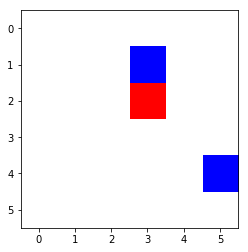

In [129]:
%matplotlib inline

bkg = np.zeros((h,w,3), dtype = np.float32)
bkg[bkg == 0] = 255

allpicks = np.zeros((h,w,4), dtype = np.float32)
bkg = allpicks.copy()
allpicks[:,:,0] = picks
allpicks[:,:,3][picks != 0] = 1
allpicks[:,:,2] = otherpicks
allpicks[:,:,3][otherpicks != 0] = 1
allpicks[allpicks == 0] = np.nan
imshow(bkg)
imshow(allpicks)
plt.show()